## S&P 500 Anomaly Detector

The goal is to detect which days the return were anomalous based on some sparse metric.  We should understand the anomalous behavior using several factos:
<ol>
    <li> Did S&amp;P 500 move because only large cap stocks moved?
    <li> Did a large number of S&amp;P 500 constituents move?
    <li> Given that markets are mean reverting, how long does this movement last?
</ol>

<p> There are several things to consider:
<ol>
    <li> What makes a S&amp;P 500 return anomalous? Is it an absolute/threshold value?      
    <li> Should we use the same threshold for each ticker or should we use a different ticker?
    <li> Given, markets are semi-efficient, especially large cap stocks should we use a moving average?
    <li> Should we use sector ETF with ARIMA type model or absolute value?
</ol>

In [32]:
import numpy as np
import os
import sys
import pandas as pd
from dateutil import parser
import scipy.sparse

from sklearn.metrics import confusion_matrix

import datetime
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

# from dimredu.denseSolvers import denseToSparse as denseToSparse
# from dimredu.sRPCAviaADMMFast import sRPCA as sRPCA
# from numpy.linalg import norm

In [33]:
sp500_df = pd.read_csv(r'C:\phd\input\rpca\GSPC.csv')
sp500_df = sp500_df.set_index('Date')
sp500_df.index = pd.to_datetime(sp500_df.index)
df_ = sp500_df[['Adj Close']].copy()
df_returns = np.log(df_/df_.shift())
sp500_returns_df = df_returns.iloc[1:].copy()
sp500_returns_df.columns = ['Return']
sp500_returns_df['Adj Close'] = df_.ix[sp500_returns_df.index]['Adj Close']

We are using 66% of dates as training set.  17% is used for validation and 17% is used for testing.

In [65]:
def train_test_split(df, training_pct, validation_pct):
    training_set_end_idx = int(df.shape[0] * training_pct)
    validation_set_end_idx = int(df.shape[0] * (training_pct+ validation_pct))
    m_training = df[0:training_set_end_idx].copy()
    m_validation = df[training_set_end_idx:validation_set_end_idx].copy()
    m_test = df[validation_set_end_idx:].copy()
    return m_training, m_validation, m_test

def get_sp500_anomalies(df, threshold):
    df_anomalies = df.copy()
    df_anomalies.drop('Adj Close', axis=1, inplace=True)
    df_anomalies[abs(df_anomalies) < threshold] = 0
    df_anomalies[df_anomalies < 0] = -1
    df_anomalies[df_anomalies > 0] = +1
    return df_anomalies

def plot_sp500(training_df, validation_df, test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    axes[0].plot(training_df.index, training_df['Adj Close'])
    axes[0].set_title('Training S&P 500 Adj Close')
    axes[0].xaxis_date()
    axes[0].set_ylim(600, 3000)
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    axes[1].plot(validation_df.index, validation_df['Adj Close'])
    axes[1].set_title('Validation S&P 500 Adj Close')
    axes[1].xaxis_date()
    axes[1].set_ylim(600, 3000)
    axes[1].xaxis.set_major_formatter(date_format)

    axes[2].plot(test_df.index, test_df['Adj Close'])
    axes[2].set_title('Test S&P 500 Adj Close')
    axes[2].xaxis_date()
    axes[2].set_ylim(600, 3000)
    axes[2].xaxis.set_major_formatter(date_format)
    
def plot_sp500_anomalies(training_df, validation_df, test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    axes[0].plot(training_df.index, training_df)
    axes[0].set_title('Training S&P 500 Anomalies')
    axes[0].xaxis_date()
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    axes[1].plot(validation_df.index, validation_df)
    axes[1].set_title('Validation S&P 500 Anomalies')
    axes[1].xaxis_date()
    axes[1].xaxis.set_major_formatter(date_format)

    axes[2].plot(test_df.index, test_df)
    axes[2].set_title('Test S&P 500 Anomalies')
    axes[2].xaxis_date()
    axes[2].xaxis.set_major_formatter(date_format)
    
def get_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\returns\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\returns\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\returns\test'
    return output_root_dir

def get_euclidean_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\euclidean-distances\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\euclidean-distances\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\euclidean-distances\test'
    return output_root_dir

def get_kl_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\kl-divergence\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\kl-divergence\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\kl-divergence\test'
    return output_root_dir

def get_sp500_anomalies_by_dataset_type(dataset_type):
    if "training" == dataset_type:
        return sp500_training_anomalies
    elif "validation" == dataset_type:
        return sp500_validation_anomalies
    else:
        return sp500_test_anomalies    
    
def get_full_path_2_save(root_dir, filename):
    full_path = os.path.join(root_dir, filename)    
    return full_path

def load_sparse_matrices(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()    
    return sparse_matrix, dense_matrix    

In [70]:
sp500_training_df, sp500_validation_df, sp500_test_df = train_test_split(sp500_returns_df, 0.66, 0.17)

threshold = 0.02
sp500_training_anomalies = get_sp500_anomalies(sp500_training_df, threshold)
sp500_validation_anomalies = get_sp500_anomalies(sp500_validation_df, threshold)
sp500_test_anomalies = get_sp500_anomalies(sp500_test_df, threshold)

In [73]:
D.shape

(503, 549)

#### Plot S&P 500 Training, Validation, and Test

In [5]:
# plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
# plot_sp500_anomalies(sp500_training_anomalies, sp500_validation_anomalies, sp500_test_anomalies)

### $1^{st}$ order - Returns 

In [6]:
training_root_dir = r'C:\phd\rpca\output\returns\training'
validation_root_dir = r'C:\phd\rpca\output\returns\validation'
test_root_dir = r'C:\phd\rpca\output\returns\test'

In [78]:
lam = 0.01
S, D = load_sparse_matrices(r'C:\phd\rpca\output\kl-divergence\training', lam)
D.shape[0]*D.shape[1]

3818116

In [20]:
S_df = pd.DataFrame(D)

In [27]:
sum(S_df[abs(S_df) < 0.01].count())

166504

In [17]:
ticker_threshold = 0.03
D[abs(D) < ticker_threshold] = 0
D[D < 0] = -1
D[D > 0] = +1
nnz = np.sum(abs(D), axis=1)
S_df = pd.DataFrame(nnz)

In [37]:
np.sum(abs(nnz))

46268.0

In [335]:
# summary = S_df['NNZ'].describe(percentiles=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85])
# summary['15%']
# sp500_training_anomalies.ix[S_df.index]['Return']

In [365]:
S_df = pd.DataFrame(nnz)
S_df.columns = ['NNZ']
S_df.index = pd.to_datetime(sp500_validation_anomalies.index)
S_df['NNZ_PCT_CHGN'] = (S_df['NNZ']/S_df['NNZ'].shift() - 1)
S_df.fillna(0, inplace=True)

S_df['NNZ_MA_5D'] = S_df['NNZ'].rolling(5).mean()
S_df.fillna(0, inplace=True)

S_df['NNZ_MA_5D_CHGN'] = (S_df['NNZ_MA_5D']/S_df['NNZ_MA_5D'].shift() - 1)
S_df.replace([np.inf, -np.inf], np.nan, inplace=True)
S_df.fillna(0, inplace=True)


# Strategy 1: If the % change is NNZ greater than 25%, it is an anamoly
S_df['SP500_RETURN'] = sp500_validation_anomalies.ix[S_df.index]['Return']
S_df.SP500_RETURN = S_df.SP500_RETURN.astype(int)
S_df['SP500_ANOMALIES'] = np.abs(S_df['SP500_RETURN'])

# several conditions are used to map the NNZ into 1 number
# S_df['CONSTITUENT_ANOMALIES'] = np.where(S_df['NNZ'] < 175, 0, 
#                              np.where((S_df['NNZ'] >= 350) | (S_df['NNZ_MA_5D'] >= 350), 1, 
#                                       np.where((abs(S_df['NNZ_MA_5D_CHGN']) > 0.1) | (abs(S_df['NNZ_PCT_CHGN']) > 0.15), 1, 0)))  # S_df['NNZ'].median()

S_df['CONSTITUENT_ANOMALIES'] = np.where((abs(S_df['NNZ_MA_5D_CHGN']) > 0.1) & (abs(S_df['NNZ_PCT_CHGN']) > 0.15), 1, 0)
S_df['LAMBDA'] = lam

In [364]:
S_df.to_csv(r'C:\phd\rpca\debug\S_validation_dataframe.csv')

In [336]:
# S_df['MA_5'] = S_df['NNZ'].rolling(5).mean()
# S_df['MA_10'] = S_df['NNZ'].rolling(10).mean()

# temp = (S_df/S_df.shift() - 1)

# temp.head()

# S_df.head(n=15)

# sp500_training_anomalies.tail()

# S_df.plot()

In [317]:
def plot_Sparse_anomalies(training_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    axes[0].plot(training_df.index, training_df['CHGN_GT_25_PCT'])
    axes[0].set_title('Training Sparse Anomalies')
    axes[0].xaxis_date()
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    axes[1].plot(training_df.index, training_df['CHGN_GT_25_PCT'])
    axes[1].set_title('Validation Sparse Anomalies')
    axes[1].xaxis_date()
    axes[1].xaxis.set_major_formatter(date_format)

    axes[2].plot(training_df.index, training_df['CHGN_GT_25_PCT'])
    axes[2].set_title('Test Sparse Anomalies')
    axes[2].xaxis_date()
    axes[2].xaxis.set_major_formatter(date_format)    

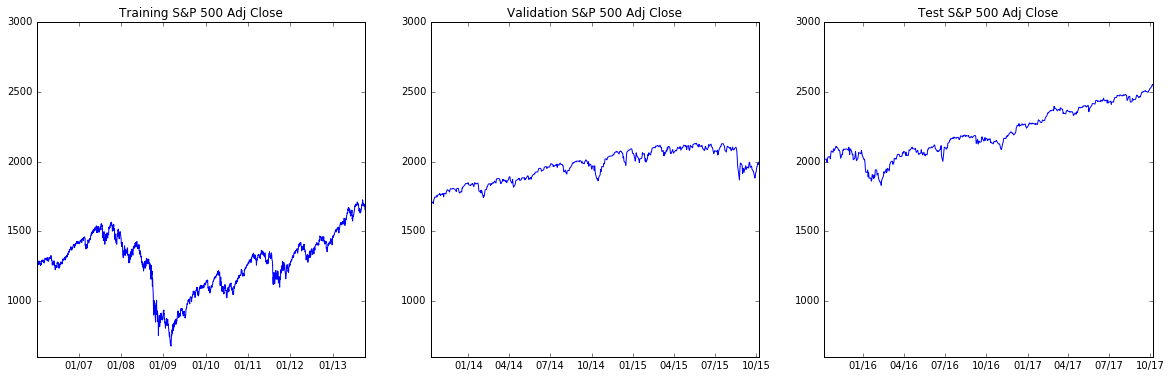

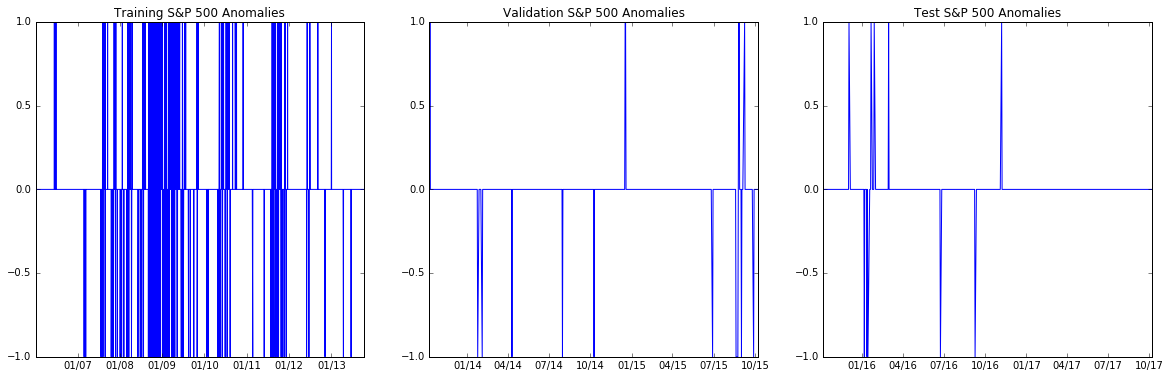

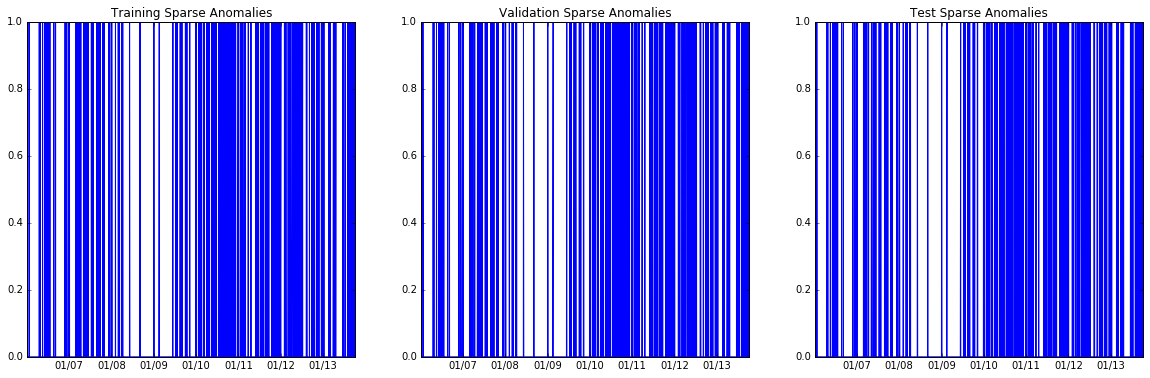

In [318]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(sp500_training_anomalies, sp500_validation_anomalies, sp500_test_anomalies)
plot_Sparse_anomalies(S_df)

In [350]:
cm = confusion_matrix(S_df['SP500_ANOMALIES'], S_df['CONSTITUENT_ANOMALIES'])

In [351]:
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

### <font color="red">DEBUGGING SECTION</font>

In [49]:
lam_list = [19, 17, 15, 13, 11, 9, 7, 5, 3, 1, 
            0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 
            0.02, 0.0175, 0.015, 0.0125, 0.010, 0.0075, 0.002]
dataset_types = ["test"]
for dataset_type in dataset_types:
    output_root_dir = get_output_root_dir(dataset_type)
    for _lam in lam_list:    
        S, D = load_sparse_matrices(output_root_dir, _lam)
        D_df = pd.DataFrame(D)
        filename = r'C:\phd\rpca\output\returns\debug\\' + dataset_type + r'\lambda_' + str(_lam) + "_" + dataset_type + ".csv"
        D_df.to_csv(filename)

C:\phd\rpca\output\returns\test\lambda_19_S.npz
C:\phd\rpca\output\returns\test\lambda_17_S.npz
C:\phd\rpca\output\returns\test\lambda_15_S.npz
C:\phd\rpca\output\returns\test\lambda_13_S.npz
C:\phd\rpca\output\returns\test\lambda_11_S.npz
C:\phd\rpca\output\returns\test\lambda_9_S.npz
C:\phd\rpca\output\returns\test\lambda_7_S.npz
C:\phd\rpca\output\returns\test\lambda_5_S.npz
C:\phd\rpca\output\returns\test\lambda_3_S.npz
C:\phd\rpca\output\returns\test\lambda_1_S.npz
C:\phd\rpca\output\returns\test\lambda_0.9_S.npz
C:\phd\rpca\output\returns\test\lambda_0.8_S.npz
C:\phd\rpca\output\returns\test\lambda_0.7_S.npz
C:\phd\rpca\output\returns\test\lambda_0.6_S.npz
C:\phd\rpca\output\returns\test\lambda_0.5_S.npz
C:\phd\rpca\output\returns\test\lambda_0.4_S.npz
C:\phd\rpca\output\returns\test\lambda_0.3_S.npz
C:\phd\rpca\output\returns\test\lambda_0.2_S.npz
C:\phd\rpca\output\returns\test\lambda_0.1_S.npz
C:\phd\rpca\output\returns\test\lambda_0.05_S.npz
C:\phd\rpca\output\returns\test\la

In [57]:
output_root_dir = get_output_root_dir("test")

S, D = load_sparse_matrices(output_root_dir, 0.01)
D[abs(D) < 0.02] = 0
nnz = np.count_nonzero(D, axis=1)
df = pd.DataFrame(nnz)
np.sum(df)

C:\phd\rpca\output\returns\test\lambda_0.02_S.npz


0    46268
dtype: int64

In [80]:
lam_list = [19, 17, 15, 13, 11, 9, 7, 5, 3, 1, 
            0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 
            0.02, 0.0175, 0.015, 0.0125, 0.010, 0.0075, 0.002]
dataset_types = ["test"]
for dataset_type in dataset_types:
    output_root_dir = get_output_root_dir(dataset_type)
    for _lam in lam_list:    
        S, D = load_sparse_matrices(output_root_dir, _lam)
        D[abs(D) < 0.01] = 0
        nnz = np.count_nonzero(D, axis=1)
        df = pd.DataFrame(nnz)
        total_nnz = np.sum(df)
        print("%d" % total_nnz)

5
7
10
18
38
92
226
593
2156
37041
44349
52473
60659
67747
72908
77202
83253
91658
111388
112023
112023
112023
112023
112023
112023
112023
112023


In [81]:
lam_list = [19, 17, 15, 13, 11, 9, 7, 5, 3, 1, 
            0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 
            0.02, 0.0175, 0.015, 0.0125, 0.010, 0.0075, 0.002]

training_root_dir = r'C:\phd\rpca\output\returns\training'
validation_root_dir = r'C:\phd\rpca\output\returns\validation'
test_root_dir = r'C:\phd\rpca\output\returns\test'

# -------------------------------------------------------------
# changes less than 4% are considered not anomalous.
# TODO: This can be later enhanced with sector ETFs
# -------------------------------------------------------------
ticker_threshold = 0.02

dataset_types = ["training", "validation", "test"]

result_df = pd.DataFrame(columns=['datatype', 'lambda', 'TP', 'TN', 'FP', 'FN']) 

i = 0

for dataset_type in dataset_types:
    for _lam in lam_list:    
        output_root_dir = get_output_root_dir(dataset_type)
        S, D = load_sparse_matrices(output_root_dir, _lam)
        D[abs(D) < ticker_threshold] = 0
        
        # number of non zero elements per day
        nnz = np.count_nonzero(D, axis=1)

        # calculate NNZ - number of non zero elements
        # increase or decrease on a daily basis
        sp500_anomalies = get_sp500_anomalies_by_dataset_type(dataset_type)
        S_df = pd.DataFrame(nnz)
        S_df.columns = ['NNZ']
        S_df.index = pd.to_datetime(sp500_anomalies.index)
        S_df['NNZ_PCT_CHGN'] = (S_df['NNZ']/S_df['NNZ'].shift() - 1)
        S_df.fillna(0, inplace=True)

        # to avoid daily fluctuations, we leverage moving average
        # because these are liquid stocks we only use a week, 5 trading days.
        # also calculate the fluctuations in these
        S_df['NNZ_MA_5D'] = S_df['NNZ'].rolling(5).mean()
        S_df.fillna(0, inplace=True)

        S_df['NNZ_MA_5D_CHGN'] = (S_df['NNZ_MA_5D']/S_df['NNZ_MA_5D'].shift() - 1)
        S_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        S_df.fillna(0, inplace=True)


        # Strategy 1: If the % change is S&P 500 is greater than 2.5%, it is an anamolous return
        S_df['SP500_RETURN'] = sp500_anomalies.ix[S_df.index]['Return']
        S_df.SP500_RETURN = S_df.SP500_RETURN.astype(int)
        S_df['SP500_ANOMALIES'] = np.abs(S_df['SP500_RETURN'])

        # -----------------------------------------------------------------------------------------------------------------------
        # several conditions are used to map the NNZ into 1 number
        # 175 is approximately 33% of 540 constituents.  Note, we keep the constituents consistent across years.
        # Index change is avoided.
        # 350 is 70% of 500.  So if a large number of non-zero elements are there then the constituents are anomalous.
        # We also want to limit to large changes.  So the change in moving average of NNZ and actual change in NNZ is taken 
        # into account too.
        # All these determine if the contituents are anomalous.
        # -----------------------------------------------------------------------------------------------------------------------
        S_df['CONSTITUENT_ANOMALIES'] = np.where((abs(S_df['NNZ_MA_5D_CHGN']) > 0.1) & (abs(S_df['NNZ_PCT_CHGN']) > 0.15), 1, 0)
        S_df['LAMBDA'] = lam
        S_df['DATASET_TYPE'] = dataset_type

        # confusion matrix
        cm = confusion_matrix(S_df['SP500_ANOMALIES'], S_df['CONSTITUENT_ANOMALIES'])

        TP = cm[1,1]
        TN = cm[0,0]
        FP = cm[0,1]
        FN = cm[1,0]

        result_df.loc[i] = [dataset_type, _lam, TP, TN, FP, FN]

        filename = r'C:\phd\rpca\results\returns\\' + dataset_type + r'\lambda_' + str(_lam) + "_" + dataset_type + ".csv"
        S_df.to_csv(filename)
        
        i = i + 1
        
result_df.to_csv(r'C:\phd\rpca\results\returns\result_df.csv')

In [82]:
result_df.head()

datatype  lambda   TP      TN    FP     FN
0  training    19.0  0.0  1741.0   0.0  213.0
1  training    17.0  0.0  1741.0   0.0  213.0
2  training    15.0  0.0  1741.0   0.0  213.0
3  training    13.0  0.0  1740.0   1.0  213.0
4  training    11.0  2.0  1731.0  10.0  211.0